/home/kairaj5456/.local/bin/new/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


Bagging Accuracy: 0.9820


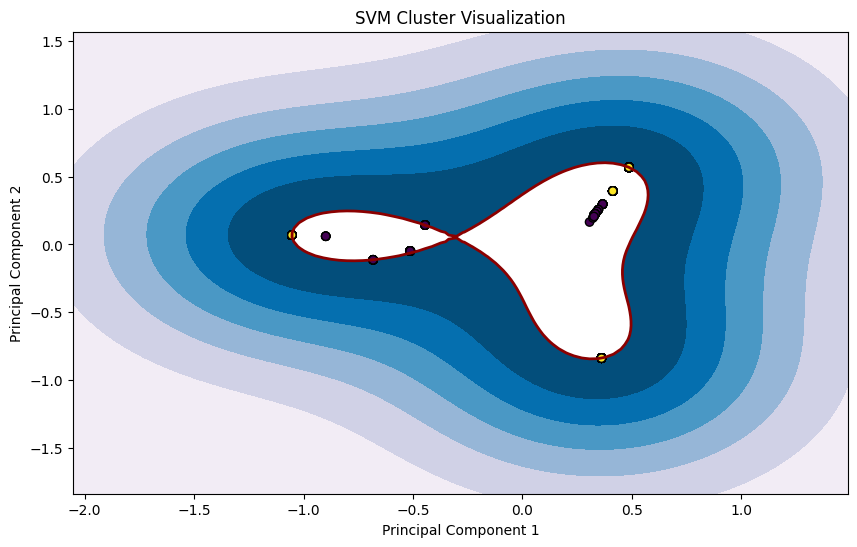

In [6]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load the dataset
df = pd.read_csv('Apache_2k_modified.csv')

# Feature Extraction (TF-IDF on 'Content' and encoding 'Level')
label_encoder = LabelEncoder()
df['Level_encoded'] = label_encoder.fit_transform(df['Level'])

tfidf = TfidfVectorizer(max_features=100)
content_tfidf = tfidf.fit_transform(df['Content']).toarray()
X = np.hstack((df[['Level_encoded']].values, content_tfidf))

# Bagging with multiple anomaly detectors
iso_forest = IsolationForest(contamination=0.05, random_state=42)
lof = LocalOutlierFactor(n_neighbors=20)
ocsvm = OneClassSVM(kernel='rbf', nu=0.05)

# Predicting Anomalies
iso_pred = iso_forest.fit_predict(X)
lof_pred = lof.fit_predict(X)
ocsvm_pred = ocsvm.fit_predict(X)

# Majority Voting for Final Decision
final_pred = np.sign(iso_pred + lof_pred + ocsvm_pred)
final_pred[final_pred > 0] = 1  # Majority is normal
final_pred[final_pred <= 0] = -1  # Majority is anomaly

# Accuracy (assuming Isolation Forest as pseudo ground truth)
accuracy = accuracy_score(iso_pred, final_pred)
print(f"Bagging Accuracy: {accuracy:.4f}")

# Visualizing SVM clusters using PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

ocsvm.fit(X_reduced)
xx, yy = np.meshgrid(np.linspace(X_reduced[:, 0].min()-1, X_reduced[:, 0].max()+1, 100),
                     np.linspace(X_reduced[:, 1].min()-1, X_reduced[:, 1].max()+1, 100))
Z = ocsvm.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=final_pred, cmap=plt.cm.viridis, edgecolors='k')
plt.title("SVM Cluster Visualization")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()
